In [16]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [36]:
################################
# Imports
################################

import pandas as pd
import h5py
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import glob
import re
from multiprocessing import cpu_count
from multiprocessing import Pool

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import os
import sys
import subprocess
from random import sample
from tqdm import tqdm
from functools import partial

from sklearn.metrics import confusion_matrix


import librosa
import soundfile as sf

In [37]:
################################
# configs
################################

#################
# spectrogram
#################

# Mean of flute = -6.438913345336914
# Median of flute = -6.118330955505371
# stdDev of flute = 4.377377986907959
# Max of flute = 1.8442230224609375
# Min of flute = -39.0754280090332

# Mean of piano = -6.015857219696045
# Median of piano = -5.299488544464111
# stdDev of piano = 4.420877456665039
# Max of piano = 1.5825170278549194
# Min of piano = -40.520179748535156

spectrogramStats = {
                    'flute': {'mean': -6.438913345336914, 'median': -6.118330955505371, 'stdDev': 4.377377986907959, 'max': 1.8442230224609375, 'min': -39.0754280090332},
                    'piano': {'mean': -6.015857219696045, 'median': -5.299488544464111, 'stdDev': 4.420877456665039, 'max': 1.5825170278549194, 'min': -40.520179748535156}
                    }

# standardizationStyleOptions = normal, logNormal, uniform
# following needs to be 'SUBTRACTED' from the data
centerOffset = {
                'flute': {'normal': spectrogramStats['flute']['mean'], 'logNormal': spectrogramStats['flute']['mean'], 'uniform': (spectrogramStats['flute']['min'] + spectrogramStats['flute']['max'])/2},
                'piano': {'normal': spectrogramStats['piano']['mean'], 'logNormal': spectrogramStats['piano']['mean'], 'uniform': (spectrogramStats['piano']['min'] + spectrogramStats['piano']['max'])/2}
                }

# following needs to be 'DIVIDED' to the data
divFactor = {
            'flute': {'normal': 3*spectrogramStats['flute']['stdDev'], 'logNormal': (1.1*spectrogramStats['flute']['max'] - spectrogramStats['flute']['mean']) , 'uniform': 1*(spectrogramStats['flute']['max'] - spectrogramStats['flute']['min'])/2},
            'piano': {'normal': 3*spectrogramStats['piano']['stdDev'], 'logNormal': (1.1*spectrogramStats['piano']['max'] - spectrogramStats['piano']['mean']) , 'uniform': 1*(spectrogramStats['piano']['max'] - spectrogramStats['piano']['min'])/2}
            }


####################
# training params
####################
STANDARDIZATION_STYLE = 'uniform'
BATCH_SIZE = 4
NUM_WORKERS = 2
NUM_EPOCHS = 200
LEARNING_RATE = 0.0001
LAMBDA_CYCLE = 10
LAMBDA_IDENTITY = 5
GRADIENT_PENALTY = 0
ADAM_BETA1 = 0
ADAM_BETA2 = 0.9
NUM_RESIDUALS = 6

####################
# checkpoint options
####################
SAVE_CHECKPOINTS = True

####################
# find GPU device
####################
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (f'Device = {DEVICE}, # of CUDA devices = {torch.cuda.device_count()}')


###################
# add fileTag
###################
fileTag = f'lr_{LEARNING_RATE}_cyc_{LAMBDA_CYCLE}_id_{LAMBDA_IDENTITY}_b1_{ADAM_BETA1}_b2_{ADAM_BETA2}_numRes_{NUM_RESIDUALS}_gp_{GRADIENT_PENALTY}_stdStyle_{STANDARDIZATION_STYLE}'

Device = cpu, # of CUDA devices = 0


In [38]:
################################
# generator
################################

class EncoderConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_act=True, use_tanh = False, **kwargs):
        super().__init__()
        self.encoderConv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs),
            nn.InstanceNorm2d(out_channels),
            (nn.Tanh() if use_tanh else nn.ReLU(inplace=True)) if use_act else nn.Identity()
        )

    def forward(self, x):
        return self.encoderConv(x)


class DecoderConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_act=True, use_tanh = False):
        super().__init__()
        
        # nearest neighbor upsample + same convolution
        self.decoderConv = nn.Sequential(            
            nn.Upsample(scale_factor = 2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=0),
            nn.InstanceNorm2d(out_channels),
            (nn.Tanh() if use_tanh else nn.ReLU(inplace=True)) if use_act else nn.Identity()
        )

    def forward(self, x):
        return self.decoderConv(x)
    

class ResidualBlock(nn.Module):
    def __init__(self, channels, use_tanh = False):
        super().__init__()
        self.block = nn.Sequential(
            EncoderConvBlock(channels, channels, use_act = True,  use_tanh = use_tanh, kernel_size=3, stride = 1, padding=1),
            EncoderConvBlock(channels, channels, use_act = False, use_tanh = use_tanh, kernel_size=3, stride = 1, padding=1)
        )

    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    
    def __init__(self, img_channels, use_tanh = False, num_features = 16, num_residuals=6):
        
        super().__init__()
        
        # same convolution. output channels = 16
        self.initial = nn.Sequential(            
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.ReLU(inplace=True)
        )
        
        
        self.down_blocks = nn.ModuleList(
            [
                # output shape = floor((W - F + 2P) / S) + 1 . 
                # Wout x Hout = 128 x 168, for Win x Hin = 256 x 336, output channels = 32
                EncoderConvBlock(num_features, num_features*2, use_act = True, use_tanh = use_tanh, kernel_size=3, stride=2, padding=1),
                
                # Wout x Hout = 64 x 84, for Win x Hin = 128 x 168, output channels = 64
                EncoderConvBlock(num_features*2, num_features*4, use_act = True, use_tanh = use_tanh, kernel_size=3, stride=2, padding=1),
            ]
        )

        # same convolutions in residual blocks. Shape remains 64 x 86, numChannels = 64
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(num_features*4, use_tanh = use_tanh) for _ in range(num_residuals)]
        )

        self.up_blocks = nn.ModuleList(
            [
                # Wout x Hout = 128 x 168, numChannels = 32
                DecoderConvBlock(num_features*4, num_features*2, use_act = True, use_tanh = use_tanh),
                
                # Wout x Hout = 256 x 336, numChannels = 16
                DecoderConvBlock(num_features*2, num_features, use_act = True, use_tanh = use_tanh)
            ]
        )

        # same convolution, numChannels = 1
        self.last = nn.Conv2d(num_features, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")

    def forward(self, x):
        
        # same convolution
        x = self.initial(x)
        
        # down sampling
        for layer in self.down_blocks:
            x = layer(x)
            
        # same convolutions
        x = self.residual_blocks(x)
        
        # upsampling
        for layer in self.up_blocks:
            x = layer(x)
        
        # same convolution
        x = self.last(x)
        
        return torch.tanh(x)

    
def test():
    x = torch.randn((5,1,336,256))
    model = Generator(img_channels=1, num_features = 16, num_residuals=9)
    print (model)
    gen = model(x)    
    print(gen.shape)

    
test()

Generator(
  (initial): Sequential(
    (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode=reflect)
    (1): ReLU(inplace=True)
  )
  (down_blocks): ModuleList(
    (0): EncoderConvBlock(
      (encoderConv): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
    )
    (1): EncoderConvBlock(
      (encoderConv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
    )
  )
  (residual_blocks): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): EncoderConvBlock(
          (encoderConv): Sequential(
            (0): Conv2d(64, 64, kernel_si

torch.Size([5, 1, 336, 256])


In [39]:
def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("===> Loading Checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # Reset learning rate
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [40]:
# CQT specs

sr = 16000

# 256 samples @ 16KHz = 16ms hop time
hopLength = 256

numBins = 336
numBinsPerOctave = 48
filterScale = 0.8
numSecondsPerChunk = 4.096



In [41]:
################################
# paths to directories
################################

curDir = os.getcwd()

trainSetDir = f'{curDir}/../../dataSuperSet/processedData/trainSet'
fluteTrainSetDir = f'{trainSetDir}/flute/cqtChunks'
pianoTrainSetDir = f'{trainSetDir}/piano/cqtChunks'

# create directories to store checkpoint outputs
checkPointDir = f'{curDir}/checkPoints'
checkPointModelDir = f'{checkPointDir}/models'
checkPointImageDir = f'{checkPointDir}/images'
checkPointLossTrackingDir = f'{checkPointDir}/lossTracking'

testOutputDir = f'{curDir}/testOutputs'
os.system(f'mkdir -p {testOutputDir}')


testPianoWav = f'{curDir}/../../trialRuns/mozartPiano.wav'
testFluteWav = f'{curDir}/../../trialRuns/mozartFlute.wav'



In [42]:
# generator piano
gen_P = Generator(img_channels=1, num_residuals = NUM_RESIDUALS).to(DEVICE)

# generator piano
gen_F = Generator(img_channels=1, num_residuals = NUM_RESIDUALS).to(DEVICE)

# optimizer generator
opt_gen  = optim.Adam(list(gen_P.parameters())  + list(gen_F.parameters()),  lr = LEARNING_RATE, betas=(ADAM_BETA1, ADAM_BETA2))

load_checkpoint(f'{checkPointModelDir}/genp__{fileTag}.pth.tar', gen_P, opt_gen, LEARNING_RATE)
load_checkpoint(f'{checkPointModelDir}/genf__{fileTag}.pth.tar', gen_F, opt_gen, LEARNING_RATE)


===> Loading Checkpoint
===> Loading Checkpoint


In [43]:
# PIANO
data, sr = librosa.load(testPianoWav, sr=sr)
print ('Piano sample len =', data.shape)
pianoCqt = librosa.cqt(data, sr=sr, hop_length = hopLength, n_bins = numBins, bins_per_octave = numBinsPerOctave, filter_scale = filterScale)

# FLUTE
data, sr = librosa.load(testFluteWav, sr=sr)
print ('Flute sample len =', data.shape)
fluteCqt = librosa.cqt(data, sr=sr, hop_length = hopLength, n_bins = numBins, bins_per_octave = numBinsPerOctave, filter_scale = filterScale)

Piano sample len = (3214353,)
Flute sample len = (3214353,)


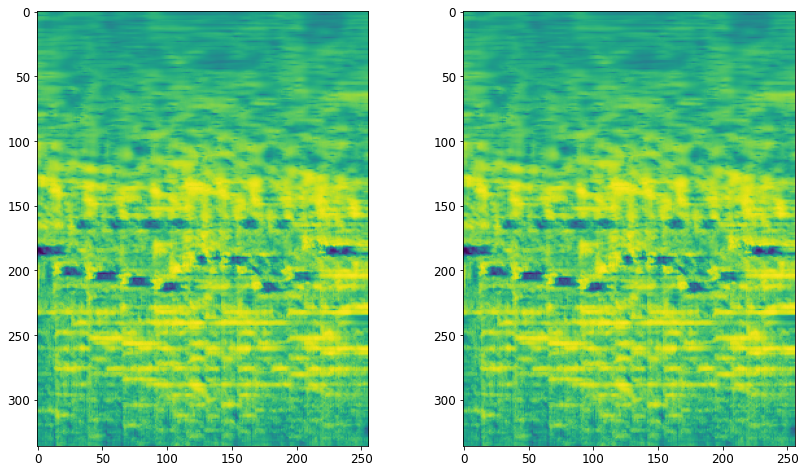

/Users/siddharthsaxena/opt/anaconda3/lib/python3.8/site-packages/librosa/core/constantq.py:670: UserWarning: hop_length=256 exceeds minimum CQT filter length=213.284.
This will probably cause unpleasant acoustic artifacts. Consider decreasing your hop length or increasing the frequency resolution of your CQT.
  warnings.warn(
/Users/siddharthsaxena/opt/anaconda3/lib/python3.8/site-packages/librosa/core/constantq.py:670: UserWarning: hop_length=256 exceeds minimum CQT filter length=213.284.
This will probably cause unpleasant acoustic artifacts. Consider decreasing your hop length or increasing the frequency resolution of your CQT.
  warnings.warn(


In [45]:
cqtSampleLength = int(sr*numSecondsPerChunk/hopLength)

# log abs CQT and phase
fluteCqtLogMag = np.log(np.abs(fluteCqt))
fluteCqtPhase = np.angle(fluteCqt)

pianoCqtLogMag = np.log(np.abs(pianoCqt))
pianoCqtPhase = np.angle(pianoCqt)

# standardization params
offsetFlute = centerOffset['flute'][STANDARDIZATION_STYLE]
offsetPiano = centerOffset['piano'][STANDARDIZATION_STYLE]
        
divFlute = divFactor['flute'][STANDARDIZATION_STYLE]
divPiano = divFactor['piano'][STANDARDIZATION_STYLE]

# normalize
fluteCqtLogMag = (fluteCqtLogMag - offsetFlute) / divFlute
pianoCqtLogMag = (pianoCqtLogMag - offsetPiano) / divPiano 


# set in evaluation mode
gen_F.eval()
gen_P.eval()

mpl.rcParams['figure.figsize'] = [14, 8]
mpl.rcParams['font.size'] = 12

with torch.no_grad():
    flute_img = torch.from_numpy(fluteCqtLogMag[None, None, :, 0:cqtSampleLength]).to(DEVICE)
    piano_img = torch.from_numpy(pianoCqtLogMag[None, None, :, 0:cqtSampleLength]).to(DEVICE)

    # generate fake piano and flute
    fake_flute, fake_piano = gen_F(piano_img).cpu().numpy(), gen_P(flute_img).cpu().numpy()
    
    # squeeze extra dims
    fake_flute, fake_piano = np.squeeze(fake_flute), np.squeeze(fake_piano)
    
    # un-normalize
    fake_flute = fake_flute * divFlute + offsetFlute
    fake_piano = fake_piano * divPiano + offsetPiano
    
    # plot to verify
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(fake_flute)
    ax[1].imshow(fake_flute)
    plt.show()
    plt.close(fig)
    
    # undo the log
    fake_flute, fake_piano = np.squeeze(np.exp(fake_flute)), np.squeeze(np.exp(fake_piano))
    
        
    # generate complex numbered values for generated CQT transforms
    generatedPianoCqt = fake_piano[:, 0:cqtSampleLength] * np.exp(1j*np.angle(fluteCqtPhase[:, 0:cqtSampleLength]))
    generatedFluteCqt = fake_flute[:, 0:cqtSampleLength] * np.exp(1j*np.angle(pianoCqtPhase[:, 0:cqtSampleLength]))
    
    generatedPianoWav = librosa.icqt(generatedPianoCqt, sr=sr, hop_length = hopLength, bins_per_octave = numBinsPerOctave, filter_scale = filterScale)
    generatedFluteWav = librosa.icqt(generatedFluteCqt, sr=sr, hop_length = hopLength, bins_per_octave = numBinsPerOctave, filter_scale = filterScale)
    
    generatedPianoWavFile = f'{testOutputDir}/generatedMozartPiano.wav'
    generatedFluteWavFile = f'{testOutputDir}/generatedMozartFlute.wav'
    
    sf.write(generatedPianoWavFile, generatedPianoWav, sr, subtype='PCM_24')
    sf.write(generatedFluteWavFile, generatedFluteWav, sr, subtype='PCM_24')
    
